In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

# Confusion Matrix Plot

In [159]:
def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
    
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# Data

In [8]:
X, y = make_classification(n_samples=600, n_features=25, n_clusters_per_class=1,
                           n_informative=15, random_state=30)
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.3, random_state=1, stratify=y)

# Bagging - RandomForestClassifier

In [9]:
from sklearn.ensemble import RandomForestClassifier

oob_score=pd.DataFrame()

for n in range(20, 161, 20):
    rf_none=RandomForestClassifier(n_estimators=n, warm_start=True,
                                   oob_score=True, max_features=None, random_state=30)
    rf_sqrt=RandomForestClassifier(n_estimators=n, warm_start=True,
                                   oob_score=True, max_features='sqrt', random_state=30)
    rf_log=RandomForestClassifier(n_estimators=n, warm_start=True,
                                  oob_score=True, max_features='log2', random_state=30)
    
    clflist=[rf_none, rf_sqrt, rf_log]
    oobs=[]
    for clf in clflist:
        clf.fit(X_train, y_train)
        oobs.append(clf.oob_score_)
        
    oob_score['n_est='+str(n)]=oobs

In [10]:
oob_score

,n_est=20,n_est=40,n_est=60,n_est=80,n_est=100,n_est=120,n_est=140,n_est=160
0,0.838095,0.840476,0.845238,0.859524,0.857143,0.852381,0.850000,0.852381
1,0.783333,0.838095,0.847619,0.852381,0.864286,0.857143,0.859524,0.857143
2,0.783333,0.826190,0.833333,0.823810,0.830952,0.838095,0.835714,0.838095


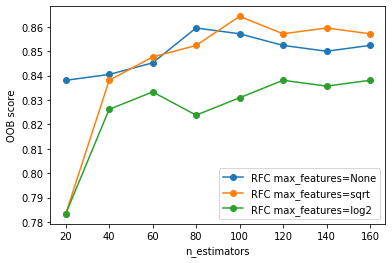

In [11]:
labelist=['RFC max_features=None', 'RFC max_features=sqrt', 'RFC max_features=log2']
for i, label in zip(range(3),labelist):
    plt.plot(np.arange(20,161,20),oob_score.iloc[i,:],marker='o',label=label)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.legend(loc='best')
plt.show()

In [16]:
rf_sqrt2=RandomForestClassifier(n_estimators=100, warm_start=True,
                                   oob_score=True, max_features='sqrt', random_state=30)
rf_log2=RandomForestClassifier(n_estimators=100, warm_start=True,
                                   oob_score=True, max_features='log2', random_state=30)
rf_none2=RandomForestClassifier(n_estimators=100, warm_start=True,
                                   oob_score=True, max_features=None, random_state=30)

for clf in [rf_sqrt2, rf_log2, rf_none2]:
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    print('%.4f' % accuracy_score(y_pred, y_test))

0.8611
0.8500
0.8167


# Boosting - XGBoost

In [90]:
import xgboost as xgb
D_train=xgb.DMatrix(X_train, label=y_train)
D_test=xgb.DMatrix(X_test, label=y_test)

## Parameter Tuning

In [78]:
xgbc=xgb.XGBClassifier(objective='binary:logistic', booster='gbtree')

parameters={
    'max_depth' : [3, 5, 7, 9, 11],
    'gamma' : [0, 0.1, 0.2, 0.3],
    'colsample_bytree' : [0.2, 0.4, 0.6, 0.8, 1],
    'eta' : [0.01, 0.05, 0.1, 0.2, 0.3]
}

gcv=GridSearchCV(xgbc, param_grid=parameters, scoring='accuracy', cv=5)
gcv.fit(X_train, y_train)

/Users/joshua/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1],
                         'eta': [0.01, 0.05, 0.1, 0.2, 0.3],
                         'gamma': [0

In [150]:
gcv.best_params_, gcv.best_score_

({'colsample_bytree': 0.8, 'eta': 0.01, 'gamma': 0, 'max_depth': 11},
 0.8738095238095238)

In [140]:
best_param={
    'objective' : 'binary:logistic',
    'booster' : 'gbtree',
    'colsample_bytree' : 0.8,
    'eta' : 0.01,
    'gamma' : 0,
    'max_depth' : 11
}

In [141]:
bestclf=xgb.train(dtrain=D_train, params=best_param, num_boost_round=60) 
D_pred=bestclf.predict(D_test)

D_pred[D_pred>=0.5]=1
D_pred[D_pred<0.5]=0
print('Non-nested CV accuracy : %.4f' % accuracy_score(D_pred, y_test))

Non-nested CV accuracy : 0.8056


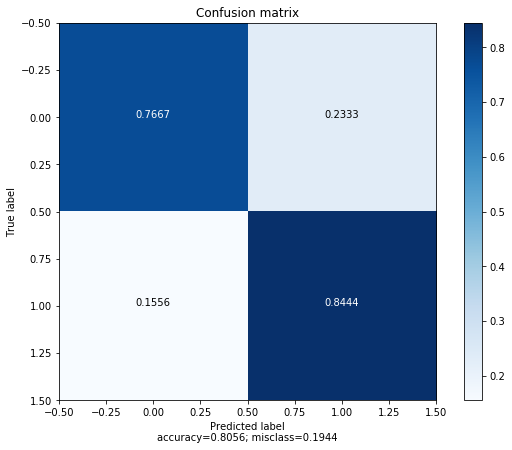

In [160]:
cm=confusion_matrix(y_test, D_pred)
plot_confusion_matrix(cm)

## Nested Cross Validation

In [138]:
gs = GridSearchCV(xgbc, param_grid=parameters, scoring='accuracy', cv=2)
scores = cross_val_score(gs, X, y, scoring='accuracy', cv=5)

/Users/joshua/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CV accuracy: 0.867 +/- 0.032


In [142]:
print('Nested CV accuracy : %.4f +/- %.4f' % (np.mean(scores), np.std(scores)))

Nested CV accuracy : 0.8666 +/- 0.0321


In [165]:
from sklearn.svm import SVC
svm=SVC(kernel='linear',C=1.0,random_state=1)
svm.fit(X_train,y_train)
y_pred=svm.predict(X_test)
print('SVM accuracy : %.4f' % accuracy_score(y_test, y_pred))

SVM accuracy : 0.8056
